## Topic Segmentation

### Fetching and preprocessing tweets

In [1]:
# Add project path to the PYTHONPATH

import os
import sys
from pathlib import Path

sys.path.append(Path(os.path.join(os.path.abspath(''), '../')).resolve().as_posix())

In [2]:
from nlp.dataset import Dataset

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/matheus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
filename = '../datasets/topic_segmentation/1183377763962671104-1182876466129887233_nobel.csv'
dataset = Dataset(filename, label_col='label', text_col='text')
dataset.load()
dataset.preprocess_texts(stemming=True, no_emoji=True)

Time to clean up: 3.83 sec


In [4]:
df = dataset.dataframe
df.cleaned.head()

0    pm abiy ahmed not exercising power control dis...
1                            cares fact received nobel
2    lithium ion batteries work earns nobel prize c...
3    congratulations nobel committee gave literatur...
4                 wow know obama nobel peace prize win
Name: cleaned, dtype: object

In [5]:
preprocessed_tweets = [tweet.split() for tweet in df.cleaned]
preprocessed_tweets[1:2]

[['cares', 'fact', 'received', 'nobel']]

In [6]:
import gensim

In [7]:
%%time
dictionary = gensim.corpora.Dictionary(preprocessed_tweets)
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)
bow_corpus = [dictionary.doc2bow(tweets) for tweets in preprocessed_tweets]

CPU times: user 282 ms, sys: 4.04 ms, total: 286 ms
Wall time: 284 ms


In [8]:
document_num = 0
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 0 ("ahmed") appears 1 time.
Word 1 ("aung") appears 1 time.
Word 2 ("control") appears 1 time.
Word 3 ("democracy") appears 1 time.
Word 4 ("like") appears 1 time.
Word 5 ("party") appears 1 time.
Word 6 ("pm") appears 1 time.
Word 7 ("power") appears 1 time.
Word 8 ("san") appears 1 time.
Word 9 ("suu") appears 1 time.
Word 10 ("winner") appears 1 time.


## LSA Implementation

In [9]:
from gensim.models import LsiModel

In [20]:
number_of_topics_lsa = 6
lsamodel = LsiModel(bow_corpus, num_topics=number_of_topics_lsa, id2word = dictionary)  # train model
lsamodel.print_topics(num_topics=number_of_topics_lsa, num_words=7)

lsa_num_topics_values = range(4, 12)
lsa_models = []
lsa_coherence_values = []

for num_topics in lsa_num_topics_values:
    model = LsiModel(bow_corpus, num_topics=num_topics, id2word = dictionary)
    lsa_models.append(model)
    
    cm = CoherenceModel(model=model, corpus=bow_corpus, texts=preprocessed_tweets, coherence='c_v')
    lsa_coherence_values.append(cm.get_coherence())   

In [13]:
import matplotlib.pyplot as plt
import numpy as np

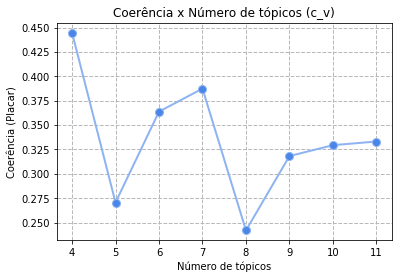

In [23]:
plt.plot(lsa_num_topics_values, lsa_coherence_values, color='#8eb3f1', linestyle='solid', linewidth = 2, 
         marker='o', markerfacecolor='#4a86e8', markersize=8) 
plt.title('Coerência x Número de tópicos (c_v)') 
plt.rc('grid', linestyle='dashed', linewidth=1, color='#b9b9b9')
plt.grid()
plt.ylabel('Coerência (Placar)') 
plt.xlabel('Número de tópicos') 

plt.show()

In [27]:
lsa_models[0].print_topics(num_topics=4, num_words=6)
lsa_models[2].print_topics(num_topics=6, num_words=6)

[(0,
  '-0.451*"ahmed" + -0.390*"prime" + -0.373*"minister" + -0.334*"ethiopia" + -0.305*"ethiopian" + -0.177*"awarded"'),
 (1,
  '0.346*"greta" + 0.254*"win" + -0.245*"prime" + -0.230*"minister" + 0.213*"thunberg" + 0.202*"one"'),
 (2,
  '-0.517*"greta" + -0.345*"thunberg" + 0.280*"awarded" + 0.275*"literature" + 0.224*"handke" + 0.219*"peter"'),
 (3,
  '0.350*"greta" + 0.302*"via" + -0.297*"pr" + 0.258*"awarded" + 0.246*"thunberg" + 0.242*"literature"'),
 (4,
  '-0.603*"pr" + 0.495*"ethiopia" + -0.252*"prime" + -0.237*"minister" + 0.205*"pm" + -0.191*"ethiopian"'),
 (5,
  '0.586*"pr" + 0.261*"pm" + -0.258*"prime" + -0.248*"minister" + 0.227*"ethiopia" + 0.180*"literature"')]

### Coherence model for LDA

In [11]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

In [12]:
%%time
num_topics_values = range(4, 12)
models = []
coherence_values = {
    'u_mass': [],
    'c_v': [],
    'c_uci': [],
    'c_npmi': []
}

for num_topics in num_topics_values:
    model = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics=num_topics, 
                                       id2word=dictionary,                                    
                                       passes=20,
                                       workers=5,
                                       iterations=400)
    models.append(model)
        
    u_mass_coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=preprocessed_tweets, coherence='u_mass')
    coherence_values['u_mass'].append(u_mass_coherence_model.get_coherence())

    c_v_coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=preprocessed_tweets, coherence='c_v')
    coherence_values['c_v'].append(c_v_coherence_model.get_coherence())
    
    c_uci_coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=preprocessed_tweets, coherence='c_uci')
    coherence_values['c_uci'].append(c_uci_coherence_model.get_coherence())
    
    c_npmi_coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=preprocessed_tweets, coherence='c_npmi')
    coherence_values['c_npmi'].append(c_npmi_coherence_model.get_coherence())

CPU times: user 2min 57s, sys: 9.85 s, total: 3min 7s
Wall time: 3min 1s


### Graph plotting

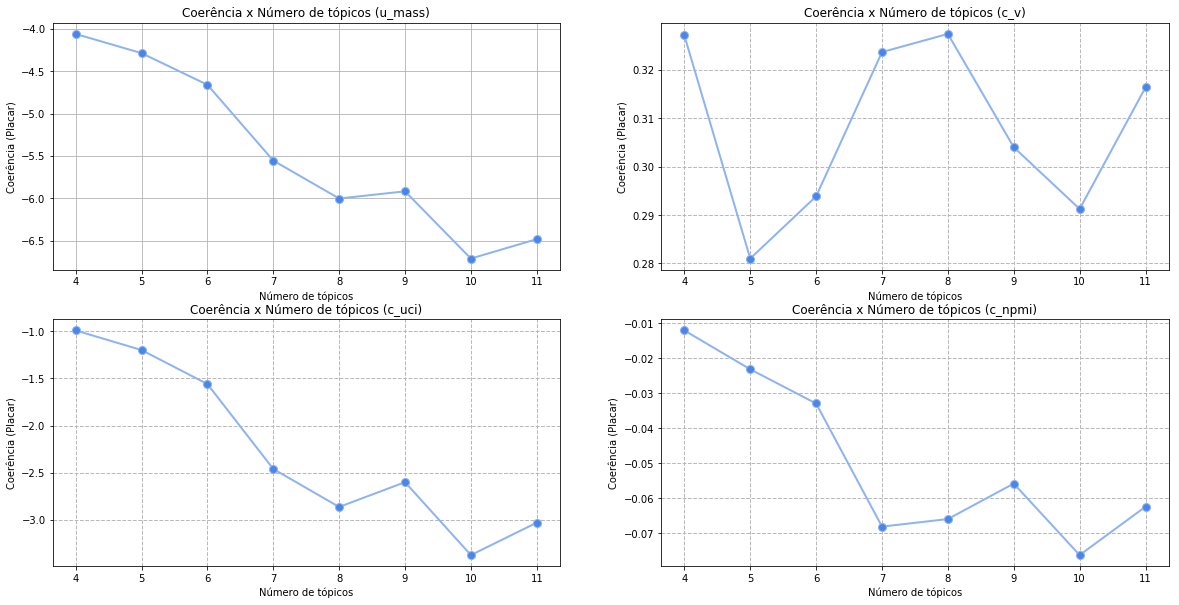

In [14]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.xticks(np.arange(min(num_topics_values), max(num_topics_values)+1, 1.0))
plt.plot(num_topics_values, coherence_values['u_mass'], color='#8eb3f1', linestyle='solid', linewidth = 2, 
         marker='o', markerfacecolor='#4a86e8', markersize=8) 
plt.title('Coerência x Número de tópicos (u_mass)') 
plt.rc('grid', linestyle='dashed', linewidth=1, color='#b9b9b9')
plt.grid()
plt.ylabel('Coerência (Placar)') 
plt.xlabel('Número de tópicos') 

plt.subplot(2,2,2)
plt.xticks(np.arange(min(num_topics_values), max(num_topics_values)+1, 1.0))
plt.plot(num_topics_values, coherence_values['c_v'], color='#8eb3f1', linestyle='solid', linewidth = 2, 
         marker='o', markerfacecolor='#4a86e8', markersize=8) 
plt.title('Coerência x Número de tópicos (c_v)') 
plt.rc('grid', linestyle='dashed', linewidth=1, color='#b9b9b9')
plt.grid()
plt.ylabel('Coerência (Placar)') 
plt.xlabel('Número de tópicos') 

plt.subplot(2,2,3)
plt.xticks(np.arange(min(num_topics_values), max(num_topics_values)+1, 1.0))
plt.plot(num_topics_values, coherence_values['c_uci'], color='#8eb3f1', linestyle='solid', linewidth = 2, 
         marker='o', markerfacecolor='#4a86e8', markersize=8) 
plt.title('Coerência x Número de tópicos (c_uci)') 
plt.rc('grid', linestyle='dashed', linewidth=1, color='#b9b9b9')
plt.grid()
plt.ylabel('Coerência (Placar)') 
plt.xlabel('Número de tópicos') 

plt.subplot(2,2,4)
plt.xticks(np.arange(min(num_topics_values), max(num_topics_values)+1, 1.0))
plt.plot(num_topics_values, coherence_values['c_npmi'], color='#8eb3f1', linestyle='solid', linewidth = 2, 
         marker='o', markerfacecolor='#4a86e8', markersize=8) 
plt.title('Coerência x Número de tópicos (c_npmi)') 
plt.rc('grid', linestyle='dashed', linewidth=1, color='#b9b9b9')
plt.grid()
plt.ylabel('Coerência (Placar)') 
plt.xlabel('Número de tópicos') 


plt.show() 

### Model visualization

In [15]:
import pyLDAvis.gensim

In [17]:
pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(models[4], bow_corpus, dictionary, sort_topics=False)

/home/matheus/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.103367  0.070070       1        1   9.836874
1      0.116739 -0.332119       2        1   9.672507
2      0.317377  0.148798       3        1  12.872351
3      0.088863  0.045739       4        1   6.929537
4     -0.058531  0.046273       5        1  13.502355
5     -0.127814  0.031578       6        1  17.737005
6     -0.113580  0.037880       7        1  12.591627
7     -0.119687 -0.048221       8        1  16.857748, topic_info=    Category         Freq             Term        Total  loglift  logprob
0    Default  1188.000000            ahmed  1188.000000  30.0000  30.0000
135  Default   774.000000            prime   774.000000  29.0000  29.0000
133  Default   731.000000         minister   731.000000  28.0000  28.0000
132  Default   729.000000        ethiopian   729.000000  27.0000  27.0000
149  Default   921.000000         ethiopia   921.000000  26.0000  26.0000
50   Default   884.000000            greta   884.000000  25.0000  25.0000
52   Default   528.000000         thunberg   528.000000  24.0000  24.0000
27   Default   435.000000            obama   435.000000  23.0000  23.0000
25   Default   478.000000       literature   478.000000  22.0000  22.0000
10   Default   617.000000           winner   617.000000  21.0000  21.0000
6    Default   544.000000               pm   544.000000  20.0000  20.0000
148  Default   361.000000          eritrea   361.000000  19.0000  19.0000
120  Default   713.000000          awarded   713.000000  18.0000  18.0000
397  Default   419.000000             wins   419.000000  17.0000  17.0000
15   Default   270.000000        chemistry   270.000000  16.0000  16.0000
22   Default   362.000000  congratulations   362.000000  15.0000  15.0000
41   Default   317.000000            peter   317.000000  14.0000  14.0000
324  Default   361.000000           handke   361.000000  13.0000  13.0000
106  Default   527.000000               no   527.000000  12.0000  12.0000
197  Default   544.000000              via   544.000000  11.0000  11.0000
287  Default   214.000000              ali   214.000000  10.0000  10.0000
915  Default   280.000000            price   280.000000   9.0000   9.0000
66   Default   425.000000            trump   425.000000   8.0000   8.0000
883  Default   265.000000           africa   265.000000   7.0000   7.0000
471  Default   242.000000           person   242.000000   6.0000   6.0000
82   Default  1066.000000               pr  1066.000000   5.0000   5.0000
44   Default   232.000000        rejection   232.000000   4.0000   4.0000
16   Default   162.000000              ion   162.000000   3.0000   3.0000
7    Default   161.000000            power   161.000000   2.0000   2.0000
567  Default   186.000000           prize:   186.000000   1.0000   1.0000
..       ...          ...              ...          ...      ...      ...
624   Topic8    32.913288             high    35.342621   1.7091  -6.1194
221   Topic8   100.544006           public   126.276398   1.5525  -5.0027
751   Topic8    26.897408           econom    29.505434   1.6878  -6.3212
181   Topic8    69.679085           giving    86.204544   1.5675  -5.3694
679   Topic8   106.911850         research   140.276215   1.5088  -4.9413
710   Topic8   132.318771          science   187.405350   1.4323  -4.7281
26    Topic8   196.909378             know   297.811462   1.3666  -4.3305
281   Topic8    82.244560              yes   108.645370   1.5020  -5.2036
19    Topic8   346.622467             work   594.403198   1.2410  -3.7650
262   Topic8    85.094727              sir   115.722198   1.4729  -5.1695
566   Topic8    56.644722           alfred    71.196259   1.5517  -5.5765
576   Topic8   162.708755            given   275.370972   1.2542  -4.5213
637   Topic8    57.865589              men    75.806870   1.5103  -5.5551
291   Topic8   160.501114         laureate   297.584656   1.1630  -4.5350
204   Topic8 